# SNN_0

This code is designed to demo the use of a Spiking Neural Network to propogate spikes between neurons. At this stage there is no learning involved, it's purely about propogating spikes between LIF neurons.

More biologically plausible neurons and learning will be introduced later.

## Running the simulation

The following code defines a set of LIF neurons and applies a stimulus to them. It then propogates the spikes to a neuron in a 2nd layer, graphing the results.

### Set up the environment

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
%matplotlib inline

###  Set up some parameters for the simulation

* Assume a consistent/single stimulus value for now that is applied for the duration of the simulation.
* Define the architecture of the SNN (layers, neurons per layer)

In [167]:
T         = 50    # total time to sumulate (msec)
dt        = 0.0125 # Simulation timestep
time      = int(T / dt)
inpt      = 1.0   # Neuron input voltage
neuron_input=np.full((time),inpt)

num_layers = 2
num_neurons = 100

### Utility functions

These functions are used to graph the results later on.

In [168]:
def plot_neuron_behaviour(time, data, neuron_type, neuron_id, y_title):
    #print ('Drawing graph with time.shape={}, data.shape={}'.format(time.shape, data.shape))
    plt.plot(time,data)
    plt.title('{} @ {}'.format(neuron_type, neuron_id))
    plt.ylabel(y_title)
    plt.xlabel('Time (msec)')
    # Graph to the data with some headroom...
    y_min = 0
    y_max = max(data)*1.2
    if y_max == 0:
        y_max = 1
    plt.ylim([y_min,y_max])   
    plt.show()

In [169]:
def plot_membrane_potential(time, Vm, neuron_type, neuron_id = 0):
    plot_neuron_behaviour(time, Vm, neuron_type, neuron_id, y_title = 'Membrane potential (V)')

def plot_spikes(time, Vm, neuron_type, neuron_id = 0):
    plot_neuron_behaviour(time, Vm, neuron_type, neuron_id, y_title = 'Spike (V)')

### Create a basic neuron class

Use LIF neuron for now, this can be made more complex over time.

Based on http://neurdon.wpengine.com/2011/01/19/neural-modeling-with-python-part-1/

Some changes to the original model:

* This class models the state of the neuron over time
* The values have been modified to make the simulation work better (not based on any biological plausability)
* Debugging has been added

In [170]:
class LIFNeuron():
    def __init__(self, debug=True):
        # Simulation config (may not all be needed!!)
        self.dt       = 0.125       # simulation time step
        self.t_rest   = 0           # initial refractory time
        
        #LIF Properties 
        self.Vm       = np.array([0])    # Neuron potential (mV)
        self.time     = np.array([0])    # Time duration for the neuron (needed?)
        self.spikes   = np.array([0])    # Output (spikes) for the neuron

        #self.output   = 0               # Neuron output
        self.t        = 0                # Neuron time step
        self.Rm       = 1                # Resistance (kOhm)
        self.Cm       = 10               # Capacitance (uF) 
        self.tau_m    = self.Rm * self.Cm # Time constant
        self.tau_ref  = 4                # refractory period (ms)
        self.Vth      = 0.75             # = 1  #spike threshold
        self.V_spike  = 1                # spike delta (V)
        self.type     = 'Leaky Integrate and Fire'
        self.debug    = debug
        if self.debug:
            print ('LIFNeuron(): Created {} neuron starting at time {}'.format(self.type, self.t))
    
    def spike_generator(self, neuron_input):
        # Create local arrays for this run
        duration = len(neuron_input)
        Vm = np.zeros(duration)  #len(time)) # potential (V) trace over time
        time = np.arange(self.t, self.t+duration)       
        spikes = np.zeros(duration)  #len(time))
        
        if self.debug:
            print ('spike_generator(): Running time period self.t={}, self.t+duration={}'
                   .format(self.t, self.t+duration))
        
        # Seed the new array with previous value of last run
        Vm[-1] = self.Vm[-1]
        
        if self.debug:
            print ('LIFNeuron.spike_generator.initial_state(input={}, duration={}, initial Vm={}, t={})'
               .format(neuron_input, duration, Vm[-1], self.t))
            
        for i in range(duration):
            if self.debug:
                print ('Index {}'.format(i))
                
            if self.t > self.t_rest:
                Vm[i]=Vm[i-1] + (-Vm[i-1] + neuron_input[i-1]*self.Rm) / self.tau_m * self.dt

                if self.debug:
                    print('spike_generator(): i={}, self.t={}, Vm[i]={}, neuron_input={}, self.Rm={}, self.tau_m * self.dt = {}'
                          .format(i,self.t, Vm[i], neuron_input[i], self.Rm, self.tau_m * self.dt))
                
                if Vm[i] >= self.Vth:
                    spikes[i] += self.V_spike
                    self.t_rest = self.t + self.tau_ref
                    if self.debug:
                        print ('*** LIFNeuron.spike_generator.spike=(self.t_rest={}, self.t={}, self.tau_ref={})'
                           .format(self.t_rest, self.t, self.tau_ref))

            self.t += self.dt
        
        # Save state
        self.Vm = np.append(self.Vm, Vm)
        self.spikes = np.append(self.spikes, spikes)
        self.time = np.append(self.time, time)
        
        if self.debug:
            print ('LIFNeuron.spike_generator.exit_state(Vm={} at iteration i={}, time={})'
                   .format(self.Vm, i, self.t))
        
        #return time, Vm, output

### Create an array of neurons

This function create a specified number of layers with specified number of neurons in each.

In [171]:
def create_neurons(num_layers, num_neurons, debug=True):
    neurons = []
    for layer in range(num_layers):
        if debug:
            print ('create_neurons(): Creating layer {}'.format(layer))
        neuron_layer = []
        for count in range(num_neurons):
            neuron_layer.append(LIFNeuron(debug=debug))
        neurons.append(neuron_layer)
    return neurons

Now create neuron model 

In [172]:
neurons = create_neurons(num_layers, num_neurons, debug=False)    

Run stimuli for each neurons in layer 0

In [173]:
stimulus_len = len(neuron_input)
layer = 0
for neuron in range(num_neurons):
    offset = random.randint(0,100)   # Simulates stimulus starting at different times
    stimulus = np.zeros_like(neuron_input)
    stimulus[offset:stimulus_len] = neuron_input[0:stimulus_len - offset]
    neurons[layer][neuron].spike_generator(stimulus)

To determine the results, graph out the membrane potential and output of a neuron in the 1st layer

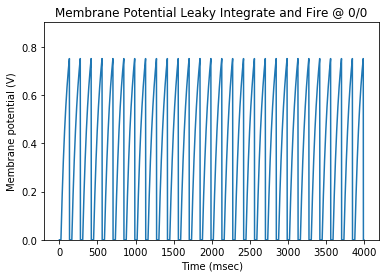

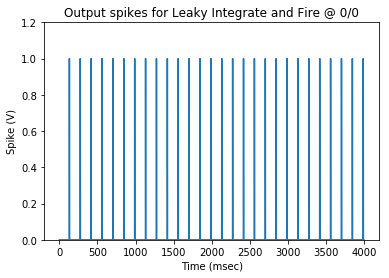

In [186]:
plot_membrane_potential(neurons[0][0].time, neurons[0][0].Vm, 'Membrane Potential {}'.format(neurons[0][0].type), neuron_id = "0/0")
plot_spikes(neurons[0][0].time, neurons[0][0].spikes, 'Output spikes for {}'.format(neurons[0][0].type), neuron_id = "0/0")

Sum the spikes from the neurons in the 1st layer (layer=0)

In [175]:
layer = 0 
layer_spikes = np.zeros_like(neurons[layer][0].spikes)
for i in range(num_neurons):
    layer_spikes += neurons[layer][i].spikes    

Get a view of the spikes from the iterations 0 to 200

In [176]:
print (layer_spikes[0:200])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  2.  3.  0.  1.  0.  0.  3.  2.  2.  2.  3.  0.  1.
  1.  1.  5.  0.  2.  1.  2.  1.  0.  2.  2.  0.  0.  0.  0.  1.  1.  0.
  0.  1.  3.  1.  1.  1.  0.  2.  0.  1.  1.  0.  1.  3.  0.  0.  1.  1.
  2.  1.  1.  0.  1.  1.  1.  0.  1.  2.  0.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  0.  2.  1.  1.  1.  1.  1.  3.  0.  1.  3.  0.  0.  2.  1.  0.
  0.  0.]


Graph summed spike train from first layer. This is the input the neuron 0 on layer 1.


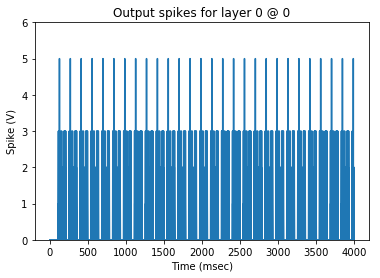

In [177]:
plot_spikes(neurons[0][0].time, layer_spikes, 'Output spikes for layer {}'.format(layer))

### Now simulate spikes propogated to a neuron on the 2nd layer

In [178]:
neurons[1][0]=Neuron(debug=False)             # Re-initialise this neuron in case of multiple runs
neurons[1][0].spike_generator(layer_spikes)   

In [182]:
start_time = 0
end_time = len(neurons[1][0].time)
print('Rendering neurons[1][0] over the time period {}:{}'.format(start_time,end_time))

Rendering neurons[1][0] over the time period 0:4002


### Graph the results

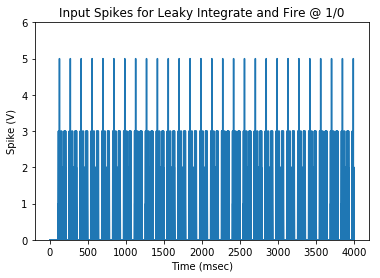

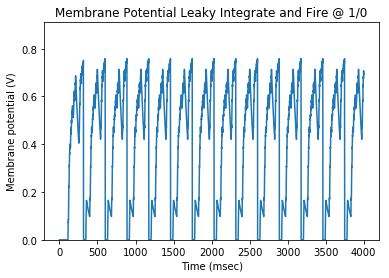

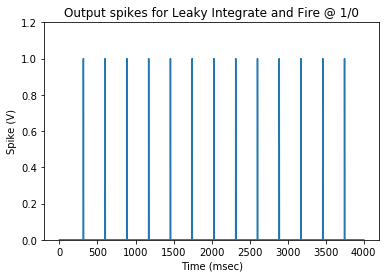

In [187]:
plot_spikes(neurons[0][0].time[start_time:end_time], layer_spikes[start_time:end_time], 
            'Input Spikes for {}'.format(neurons[1][0].type), neuron_id = "1/0")
plot_membrane_potential(neurons[1][0].time[start_time:end_time], neurons[1][0].Vm[start_time:end_time], 
            'Membrane Potential {}'.format(neurons[1][0].type), neuron_id = "1/0")
plot_spikes(neurons[1][0].time[start_time:end_time], neurons[1][0].spikes[start_time:end_time], 
            'Output spikes for {}'.format(neurons[1][0].type), neuron_id = "1/0")

## Findings

The following findings were made:
    
* The model works and it is possible to see spike trains propogate between different layers in an SNN
* Only a simple model using feedforward has been applied here
* Different spike trains are evidenced depending on the offset of the applied stimulus
* There is no real view of biological plausability here, and this code base is unlikely to offer anything in terms of a real use-case
* It has been a useful experience to understand the mechanics of a basic spiking network, and to witness it in action


In [ ]:
## Next steps

* Explore other neuron types (HK neurons for example)